In [1]:
import pygplates
import pygmt
import pandas as pd
import numpy as np
#import geopandas as gpd

%matplotlib inline
%load_ext autoreload
%autoreload 2

print(pygplates.__version__)

from gprm import ReconstructionModel, SubductionConvergence, PointDistributionOnSphere
from gprm.datasets import Reconstructions
#from gprm.utils.create_gpml import gdf2gpml, gpml2gdf


0.36.0


In [2]:
M2019 = Reconstructions.fetch_Muller2019()


In [3]:
# compute the subduction zone kinematics for a single time snapshot
# results are returned in a 'SubductionConvergence' class object

reconstruction_time = 100.

subduction_kinematics = SubductionConvergence(M2019, reconstruction_time, threshold_sampling_distance_radians=0.02)

mr = np.asarray(subduction_kinematics.df['migr_rate'], dtype=np.float64)
mo = np.asarray(subduction_kinematics.df['migr_obliq'], dtype=np.float64)

subduction_kinematics.df['ortho_migr_rate'] = pd.Series(mr*np.sin(np.radians(np.abs(mo))), index=subduction_kinematics.df.index)

#subduction_kinematics.plot('mr')

/Users/Simon/GIT/PlateTectonicTools/ptt/subduction_convergence.py:313: RuntimeWarning: Unable to find the subducting plate of the subducting sub-segment "Challenger Plateau NE margin" at 100.0Ma.
    Either the subduction polarity is not properly set or there are too many subducting plates sharing the sub-segment.
    Ignoring current sub-segment.
  warnings.warn(
/Users/Simon/GIT/PlateTectonicTools/ptt/subduction_convergence.py:313: RuntimeWarning: Unable to find the subducting plate of the subducting sub-segment "Trench during period Laramide Flat Slab" at 100.0Ma.
    Either the subduction polarity is not properly set or there are too many subducting plates sharing the sub-segment.
    Ignoring current sub-segment.
  warnings.warn(


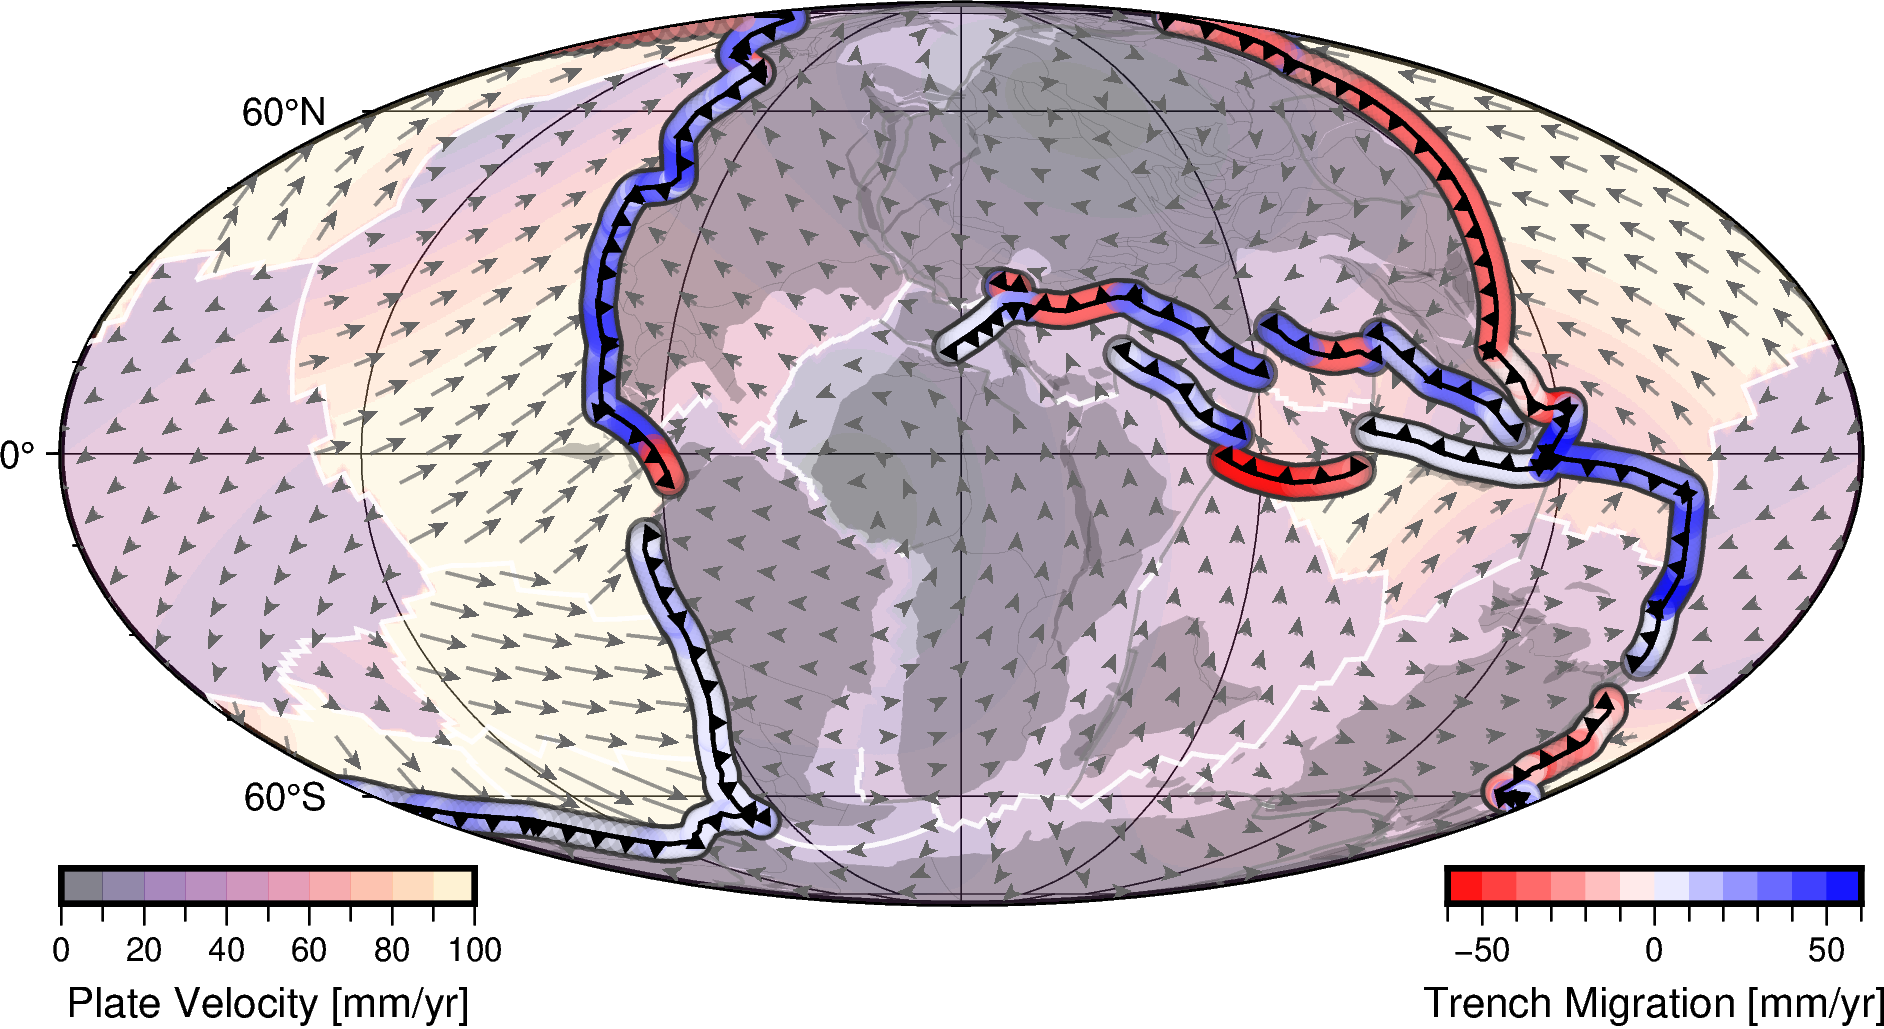

In [10]:
reconstructed_plates = M2019.plate_snapshot(reconstruction_time)


velocity_domain = PointDistributionOnSphere(distribution_type='healpix', N=32)
velocity_field = reconstructed_plates.velocity_field(velocity_domain_features=[velocity_domain.meshnode_feature])
velgrd = velocity_field.to_grid(spacing='0.25d')

velocity_domain = PointDistributionOnSphere(distribution_type='healpix', N=8)
velocity_field = reconstructed_plates.velocity_field(velocity_domain_features=[velocity_domain.meshnode_feature])


scaling=10
tmp = np.vstack((subduction_kinematics.df.lon,
                 subduction_kinematics.df.lat,
                 subduction_kinematics.df.arc_azimuth+180,
                 subduction_kinematics.df.ortho_migr_rate/scaling)).T

fig = pygmt.Figure()
fig.basemap(region='d', projection='W6i', frame='afg')

pygmt.makecpt(cmap='magma', series=[0,100,10], background='o', reverse=False, transparency=50)
fig.grdimage(grid=velgrd, cmap=True, transparency=75)

M2019.polygon_snapshot('continents', reconstruction_time).plot(fig, transparency=70, pen=None, color='gray20')

reconstructed_plates.plot_mid_ocean_ridges(fig, pen='1p,white', transparency=10)
reconstructed_plates.plot_other_boundaries(fig, pen='0.7p,gray50', transparency=40)

velocity_field.plot(fig, scaling=300., pen="0.7p,gray40", color='gray40',
                    style='V0.15c+e+a45+ggray40+n', transparency=30)

with pygmt.config(FONT_ANNOT_PRIMARY='8p', FONT_LABEL='10p'):
    fig.colorbar(position='JBL+jBL+o0.0c+w3.5c/0.3c+h', transparency=20, frame=['x+lPlate Velocity [mm/yr]'])#, box='+gwhite+p0.5p')

fig.plot(x=subduction_kinematics.df.lon,
         y=subduction_kinematics.df.lat,
         style='c0.33c', color='gray20', transparency=30)

pygmt.makecpt(cmap='polar', series=[-60,60,10], background='o', reverse=True)
fig.plot(x=subduction_kinematics.df.lon,
         y=subduction_kinematics.df.lat,
         color=subduction_kinematics.df.ortho_migr_rate*10,
         style='c0.25c', cmap=True, transparency=50)
with pygmt.config(FONT_ANNOT_PRIMARY='8p', FONT_LABEL='10p'):
    fig.colorbar(position='JBR+jBR+o0.0c+w3.5c/0.3c+h', frame=['x+lTrench Migration [mm/yr]'])#, box='+gwhite+p0.5p')


reconstructed_plates.plot_subduction_zones(fig, pen='1p,black', gap=8, size=3)

fig.savefig('./optimization.pdf', dpi=300)
fig.show(width=1000)

